# **Battle of Neighborhoods: Boston Crime Edition**

# <h2> *Applied Data Science Capstone by IBM/Coursera*

<h3> **Table of Contents** </h3>

1.<ins> Introduction: Business Problem</ins>

2.<ins> Data</ins>

3.<ins> Methodology</ins>

4.<ins>Analysis</ins>

5.<ins> Results and Discussion</ins>

6.<ins> Conclusion</ins>

<h2>Introduction: Business Problem </h2>

Boston real-estate moguls have outgrown the phase of modern office buildings, fancy restaurants and other entertainment centers, facing a new challenge: the prolific demand of secure activity venues that children can easily access without parents' unnecessary concern. 
This problem was raised by stakeholders that are interested in opening such a community center for children and young teens that can provide music lessons, dance trainings, all sorts of art and sports classes. 

In this project I will try to find an optimal location for this center, considering that the defining criteria is **security** of the vicinity. 
I will try to detect locations that are less likely to face crime incidents, more likely to contain a government venue nearby and I will use data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crimes-in-boston/offense_codes.csv
/kaggle/input/crimes-in-boston/crime.csv
/kaggle/input/crmbstn/crime.csv
/kaggle/input/boston-neighborhoods-geojson/Boston_Neighborhoods.geojson
/kaggle/input/hthkejgv/out.csv


# Data

I used two datasets available publicly, namely The Boston Crime Reports and the Boston Neighborhoods Info Geojson. Corroborating these info sources I managed to create a data set that served as basis for my analysis.

# Methodology

To extract a set of locations/neighbordoohs adequate for the business problem mentioned before, the first step was the exploration of Boston Neighborhoods and the main take-aways from the crimes committed in each neighborhood. 
Next, I comprised the info on crimes per neighborhood, locating each crime in its afferent district and tried to find the safer places via intuition. Next, I gathered information regarding the number of government buildings in each neighborhood via Foursquare and hardcodded this sum in a new, final dataset, ready for clustering. The final step was clustering the neighborhoods and analysing each one, concluding with reccomandations for possible neighborhoods suitable for the new community center. 

# Analysis

In [2]:
import json
with open('../input/boston-neighborhoods-geojson/Boston_Neighborhoods.geojson', 'r') as f:
    boston_geojson = json.load(f)
features = boston_geojson['features']
nbh_list = []
for feature in features:
    nbh_list.append(feature['properties']['Name'])
print(nbh_list)

['Roslindale', 'Jamaica Plain', 'Mission Hill', 'Longwood', 'Bay Village', 'Leather District', 'Chinatown', 'North End', 'Roxbury', 'South End', 'Back Bay', 'East Boston', 'Charlestown', 'West End', 'Beacon Hill', 'Downtown', 'Fenway', 'Brighton', 'West Roxbury', 'Hyde Park', 'Mattapan', 'Dorchester', 'South Boston Waterfront', 'South Boston', 'Allston', 'Harbor Islands']


In [3]:
from shapely.geometry import Point, shape, Polygon
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 
boston_neighborhoods = pd.DataFrame(columns=column_names)
for feature in features:
        polygon = shape(feature['geometry'])
        neighborhood_name = feature['properties']['Name']
        boston_neighborhoods = boston_neighborhoods.append({'Neighborhood': neighborhood_name,
                                          'Latitude': polygon.centroid.y,
                                          'Longitude': polygon.centroid.x}, ignore_index=True)

In [4]:
boston_neighborhoods.head()

,Neighborhood,Latitude,Longitude
0,Roslindale,42.282524,-71.126663
1,Jamaica Plain,42.307770,-71.115097
2,Mission Hill,42.331741,-71.102607
3,Longwood,42.338609,-71.105103
4,Bay Village,42.349103,-71.069032


In [5]:
boston_neighborhoods.shape

(26, 3)

In [8]:

import folium

map_boston = folium.Map(location=[42.361145, -71.057083], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(boston_neighborhoods['Latitude'], boston_neighborhoods['Longitude'], boston_neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_boston)  
    
map_boston


# Data cleaning

Since incident_number is unique I'll set it as the index. Then I'll drop location due to redundancy. More data cleaning is required. 

In [9]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

data_crime = pd.read_csv('../input/crimes-in-boston/crime.csv',encoding='latin1')
data_crime.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


In [10]:
#data_crime.set_index('INCIDENT_NUMBER', inplace = True)
data_crime['SHOOTING'].fillna(0, inplace = True)
data_crime.drop(columns = ['Location'], inplace = True)

In [11]:
data_crime.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,0,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371
1,I182070943,1402,Vandalism,VANDALISM,C11,347,0,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,0,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,0,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,0,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361


In [12]:
data_crime.isna().sum()

INCIDENT_NUMBER            0
OFFENSE_CODE               0
OFFENSE_CODE_GROUP         0
OFFENSE_DESCRIPTION        0
DISTRICT                1765
REPORTING_AREA             0
SHOOTING                   0
OCCURRED_ON_DATE           0
YEAR                       0
MONTH                      0
DAY_OF_WEEK                0
HOUR                       0
UCR_PART                  90
STREET                 10871
Lat                    19999
Long                   19999
dtype: int64

In [13]:
data_crime_od = data_crime.groupby('OFFENSE_DESCRIPTION').size().reset_index(name = 'counts').set_index('OFFENSE_DESCRIPTION').sort_values(by = 'counts', ascending = False)

In [14]:
data_crime_od

,counts
OFFENSE_DESCRIPTION,
SICK/INJURED/MEDICAL - PERSON,18783
INVESTIGATE PERSON,18754
M/V - LEAVING SCENE - PROPERTY DAMAGE,16323
VANDALISM,15154
ASSAULT SIMPLE - BATTERY,14791
...,...
ROBBERY - UNARMED - CHAIN STORE,1
ROBBERY - UNARMED - RESIDENCE,1
ROBBERY ATTEMPT - KNIFE - BANK,1


# **What are the most common crimes in Boston?**

In [15]:
df_ocg = data_crime.groupby('OFFENSE_CODE_GROUP').size().reset_index(name = 'counts').set_index('OFFENSE_CODE_GROUP').sort_values(by = 'counts', ascending = False)
df_ocg.head()

,counts
OFFENSE_CODE_GROUP,
Motor Vehicle Accident Response,37132
Larceny,25935
Medical Assistance,23540
Investigate Person,18750
Other,18075


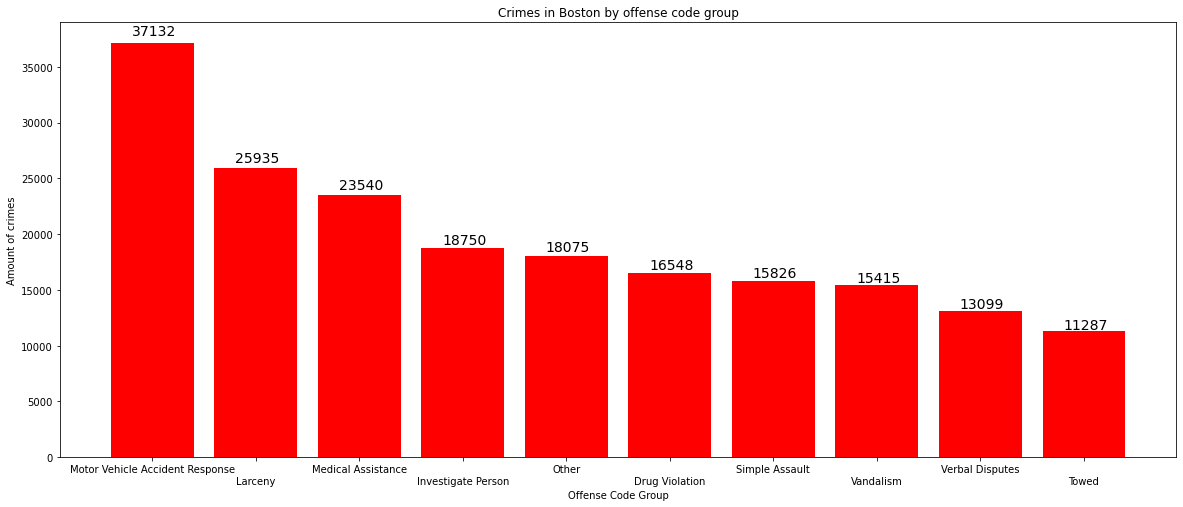

In [16]:
def multiliner(string_list, n):
    length = len(string_list)
    for i in range(length):
        rem = i % n
        string_list[i] = '\n' * rem + string_list[i]
    return string_list

fig41 = plt.figure(figsize = (20,8))
ind41 = np.arange(10)
ax41 = plt.subplot(111)
y_data = df_ocg['counts'].head(10)
df_riocg = df_ocg.reset_index()
rects = ax41.bar(ind41, y_data, width = 0.8,color = 'r')
ax41.set_xticks(ind41)
ax41.set_xticklabels(multiliner(df_ocg.index.tolist()[:10], 2))
ax41.set_xlabel('Offense Code Group')
ax41.set_ylabel('Amount of crimes')
ax41.set_title('Crimes in Boston by offense code group')
for rect in rects:
    height = rect.get_height()
    ax41.text(rect.get_x() + 0.2, 1.02 * height, height, fontsize = 14)

Since I already have the information about the neighborhoods, now I need to determine the number of crimes that take place within a neighborhood. All the crimes that did not have latitude and longitude need to be dropped so we may have some slight underestimation and distortion.

In [17]:
def point_to_neighborhood (lat, long, geojson):
    point = Point(long, lat)
    features = geojson['features']
    for feature in features:
        polygon = shape(feature['geometry'])
        neighborhood = feature['properties']['Name']
        if polygon.contains(point):
            if neighborhood == 'Chinatown' or neighborhood == 'Leather District':
                return 'Downtown'
            elif neighborhood == 'Bay Village':
                return 'South End'
            else:
                return neighborhood
    print(f'Point ({long},{lat}) is not in Boston.')
    return None

In [18]:
df_nafree = data_crime.dropna(subset = ['Lat','Long'])
df_nafree.shape

(299074, 16)

In [19]:
for index, row in df_nafree.iterrows():
    lat = df_nafree.at[index, 'Lat']
    long = df_nafree.at[index, 'Long']
    #print(index)
    #print(lat)
    #print(long)
    neighborhood = point_to_neighborhood(lat, long, boston_geojson)
    #print(neighborhood)
    df_nafree.at[index, 'Neighborhood'] = neighborhood

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-71.10616171,42.34489316) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-71.03973966,42.28458088) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston

Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-71.10696156,42.34821076) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-71.16966239,42.30110109) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-71.10696156,42.34821076) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) i

Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-71.10696156,42.34821076) is not in Boston.
Point (-71.10696156,42.34821076) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-71.10692212,42.34649653) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-71.03973966,42.28458088) is not in Boston.
Point (-71.03973966,42.28458088) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-71.03973966,42.28

Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in 

Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-71.03973966,42.28458088) is not in Boston.
Point (-71.03973966,42.28458088) is not in Boston.
Point (-1.0,-1.0) is not in Boston.


In [20]:
df_nafree.tail(10)

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Neighborhood
319063,I080542626-00,3125,Warrant Arrests,WARRANT ARREST,A1,111,0,2015-08-12 12:00:00,2015,8,Wednesday,12,Part Three,BOYLSTON ST,42.352312,-71.063705,Downtown
319064,I080542626-00,1848,Drug Violation,DRUGS - POSS CLASS B - INTENT TO MFR DIST DISP,A1,111,0,2015-08-12 12:00:00,2015,8,Wednesday,12,Part Two,BOYLSTON ST,42.352312,-71.063705,Downtown
319065,I080542626-00,1849,Drug Violation,"DRUGS - POSS CLASS B - COCAINE, ETC.",A1,111,0,2015-08-12 12:00:00,2015,8,Wednesday,12,Part Two,BOYLSTON ST,42.352312,-71.063705,Downtown
319066,I060168073-00,1864,Drug Violation,DRUGS - POSS CLASS D - INTENT MFR DIST DISP,E13,912,0,2018-01-27 14:01:00,2018,1,Saturday,14,Part Two,CENTRE ST,42.322838,-71.100967,Jamaica Plain
319067,I060168073-00,3125,Warrant Arrests,WARRANT ARREST,E13,912,0,2018-01-27 14:01:00,2018,1,Saturday,14,Part Three,CENTRE ST,42.322838,-71.100967,Jamaica Plain
319068,I050310906-00,3125,Warrant Arrests,WARRANT ARREST,D4,285,0,2016-06-05 17:25:00,2016,6,Sunday,17,Part Three,COVENTRY ST,42.336951,-71.085748,Roxbury
319069,I030217815-08,111,Homicide,"MURDER, NON-NEGLIGIENT MANSLAUGHTER",E18,520,0,2015-07-09 13:38:00,2015,7,Thursday,13,Part One,RIVER ST,42.255926,-71.123172,Hyde Park
319070,I030217815-08,3125,Warrant Arrests,WARRANT ARREST,E18,520,0,2015-07-09 13:38:00,2015,7,Thursday,13,Part Three,RIVER ST,42.255926,-71.123172,Hyde Park
319071,I010370257-00,3125,Warrant Arrests,WARRANT ARREST,E13,569,0,2016-05-31 19:35:00,2016,5,Tuesday,19,Part Three,NEW WASHINGTON ST,42.302333,-71.111565,Jamaica Plain
319072,142052550,3125,Warrant Arrests,WARRANT ARREST,D4,903,0,2015-06-22 00:12:00,2015,6,Monday,0,Part Three,WASHINGTON ST,42.333839,-71.080290,Roxbury


In [21]:
df_nbh = df_nafree.groupby('Neighborhood').size().reset_index(name = 'count').set_index('Neighborhood')


final=pd.merge(df_nbh,boston_neighborhoods,on='Neighborhood',sort=True)
final

,Neighborhood,count,Latitude,Longitude
0,Allston,8487,42.358405,-71.128563
1,Back Bay,12336,42.349861,-71.080535
2,Beacon Hill,2746,42.357050,-71.068262
3,Brighton,10766,42.348357,-71.154935
4,Charlestown,5811,42.379310,-71.063767
5,Dorchester,74834,42.298462,-71.063457
6,Downtown,23487,42.355593,-71.057651
7,East Boston,12953,42.372679,-71.015695
8,Fenway,8577,42.344767,-71.096115
9,Harbor Islands,4,42.327941,-70.968775


# Foursquare

After I have carefully obtained the list with the neighborhoods in Boston and their level of crime, we will continue with identifying the government buildings in each neighborhoods (such as police stations, city hall, fire stations, courthouse, embassies, consulates, etc. 

I will be performing this and centralizing the results in a csv file to be read next.

In [29]:
latitudes=[]
longitudes=[]
for ind in final.index: 
    latitudes.append(final['Latitude'][ind])
    longitudes.append(final['Longitude'][ind])
    
    

In [23]:
import requests
import json
gov_category = '52e81612bcbc57f1066b7a38' 


gov_venues_categories = ['4bf58dd8d48988d12a941735','4bf58dd8d48988d129941735','4bf58dd8d48988d12b941735',
                        '4bf58dd8d48988d12c951735','4bf58dd8d48988d12c941735','4bf58dd8d48988d12d941735',
                        '4bf58dd8d48988d12e941735','52e81612bcbc57f1066b7a38']

foursquare_client_id='HTEBQOT1TLOIZW5PINS2NJ02UESJS4UM4WPDMELTXSUMU0NZ'
foursquare_client_secret='O4RHCRROMFSNIFEMWR4U5UGLRTP5SYUQOJKP0ESFZ20HGM2K'

def get_categories(categories):
    return [(cat['name'], cat['id']) for cat in categories]


def get_venues_near_location(lat, lon, category, client_id, client_secret, radius=500, limit=100):
    version = '20180724'
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        client_id, client_secret, version, lat, lon, category, radius, limit)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues = [(item['venue']['id'],
                   item['venue']['name'],
                   get_categories(item['venue']['categories']),
                   (item['venue']['location']['lat'], item['venue']['location']['lng']),
                   format_address(item['venue']['location']),
                   item['venue']['location']['distance']) for item in results]        
    except:
        venues = []
    return venues




In [24]:
import requests
import json

def get_buildings(lats, lons):
    buildings = {}
    police_buildings = {}

    print('Obtaining venues around candidate locations:', end='')
    for lat, lon in lats, lons:
        venues = get_venues_near_location(lat, lon, gov_category, foursquare_client_id, foursquare_client_secret, radius=500, limit=100)
        for venue in venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            is_police=False
            if(venue[2]=='4bf58dd8d48988d12e941735'):
                is_police=True
            building = (venue_id, venue_name, venue_latlon[0], venue_latlon[1], venue_address, venue_distance, is_police)
            buildings[venue_id] = building
            if is_police:
                police_buildings[venue_id] = building
        print(' .', end='')
    print(' done.')
    return buildings, police_buildings


In [32]:
buildings, police_buildings= get_buildings(latitudes, longitudes)


Obtaining venues around candidate locations:

ValueError: too many values to unpack (expected 2)

In [33]:
final.to_csv('out.csv', index=False)


# Clustering

In [47]:
import pandas as pd
for_cluster=pd.read_csv('../input/hthkejgv/out.csv')
for_cluster

,Neighborhood,count,Latitude,Longitude,Gov_Buildings
0,Allston,8487,42.358405,-71.128563,21
1,Back Bay,12336,42.349861,-71.080535,3
2,Beacon Hill,2746,42.357050,-71.068262,34
3,Brighton,10766,42.348357,-71.154935,56
4,Charlestown,5811,42.379310,-71.063767,23
5,Dorchester,74834,42.298462,-71.063457,25
6,Downtown,23487,42.355593,-71.057651,14
7,East Boston,12953,42.372679,-71.015695,18
8,Fenway,8577,42.344767,-71.096115,22
9,Harbor Islands,4,42.327941,-70.968775,14


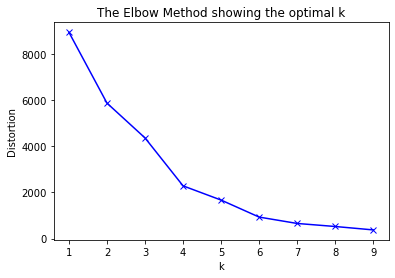

In [48]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt


for_cluster_g = for_cluster.drop('Neighborhood', 1)

plt.plot()
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(for_cluster_g)
    kmeanModel.fit(for_cluster_g)
    distortions.append(sum(np.min(cdist(for_cluster_g, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / for_cluster_g.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

 

In [49]:

kclusters = 4

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(for_cluster_g)
for_cluster.insert(0, 'Cluster Labels', kmeans.labels_)

for_cluster

,Cluster Labels,Neighborhood,count,Latitude,Longitude,Gov_Buildings
0,2,Allston,8487,42.358405,-71.128563,21
1,0,Back Bay,12336,42.349861,-71.080535,3
2,2,Beacon Hill,2746,42.357050,-71.068262,34
3,0,Brighton,10766,42.348357,-71.154935,56
4,2,Charlestown,5811,42.379310,-71.063767,23
5,1,Dorchester,74834,42.298462,-71.063457,25
6,0,Downtown,23487,42.355593,-71.057651,14
7,0,East Boston,12953,42.372679,-71.015695,18
8,2,Fenway,8577,42.344767,-71.096115,22
9,2,Harbor Islands,4,42.327941,-70.968775,14


# Results and Discussion

In [52]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors


map_clusters = folium.Map(location=[42.361145, -71.057083], zoom_start=10)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(for_cluster['Latitude'], for_cluster['Longitude'], for_cluster['Neighborhood'], for_cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [64]:
print(for_cluster[for_cluster['Cluster Labels']==0]['count'].mean())
print(for_cluster[for_cluster['Cluster Labels']==0]['Gov_Buildings'].mean())

14283.555555555555
20.77777777777778


In [65]:
print(for_cluster[for_cluster['Cluster Labels']==1]['count'].mean())
print(for_cluster[for_cluster['Cluster Labels']==1]['Gov_Buildings'].mean())

74834.0
25.0


In [66]:
print(for_cluster[for_cluster['Cluster Labels']==2]['count'].mean())
print(for_cluster[for_cluster['Cluster Labels']==2]['Gov_Buildings'].mean())

4658.25
17.0


In [67]:
print(for_cluster[for_cluster['Cluster Labels']==3]['count'].mean())
print(for_cluster[for_cluster['Cluster Labels']==3]['Gov_Buildings'].mean())

38920.0
6.0


In [75]:
recommended=pd.DataFrame(for_cluster[for_cluster['Cluster Labels']==2]['Neighborhood'])
recommended

,Neighborhood
0,Allston
2,Beacon Hill
4,Charlestown
8,Fenway
9,Harbor Islands
12,Longwood
14,Mission Hill
15,North End
16,Roslindale
19,South Boston Waterfront


As we can gather from the analysis, the cluster that comprises the safest locations in Boston are the ones listed above, as they have the best combination of low crime rate and large number of government buildings. In conclusion, these are the neighborhoods that need to be taken into account when the stakeholders will consider opening the community center. As we can see from the map, these neighborhoods are the furthest from the bay, adding extra points to the safety aspect. Moreover, the crimes that are most common in these areas are not exactly murders or thefts, but more injuries or vehicle accidents, which are not necessarily the danger that the parents adressed when initiating the safety problem. 